In [1]:
#| output: false
import src
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

td = pd.read_pickle('../results/dekodec/Prez_20220721_dekodec_split.pkl')
td.columns

Index(['M1_spikes', 'M1_unit_guide', 'MC_spikes', 'MC_unit_guide',
       'PMd_spikes', 'PMd_unit_guide', 'bin_size', 'cst_cursor_command',
       'ct_location', 'cursor_pos', 'date_time', 'hand_pos', 'idx_cstEndTime',
       'idx_cstStartTime', 'idx_ctHoldTime', 'idx_endTime', 'idx_failTime',
       'idx_goCueTime', 'idx_pretaskHoldTime', 'idx_rewardTime',
       'idx_rtHoldTimes', 'idx_rtgoCueTimes', 'idx_startTime', 'lambda',
       'monkey', 'raw_left_eye_pos', 'raw_left_pupil', 'rel_cursor_pos',
       'rel_hand_pos', 'result', 'rt_locations', 'task', 'trial_id',
       'session_date', 'M1_rates', 'MC_rates', 'PMd_rates', 'lfads_rates',
       'lfads_inputs', 'hand_vel', 'hand_acc', 'cursor_vel', 'hand_speed',
       'Time from go cue (s)', 'Time from task cue (s)', 'trialtime',
       'lfads_rates_joint_pca', 'lfads_rates_joint_pca_cst_unique',
       'lfads_rates_joint_pca_rtt_unique', 'lfads_rates_joint_pca_shared',
       'lfads_rates_joint_pca_split'],
      dtype='object')

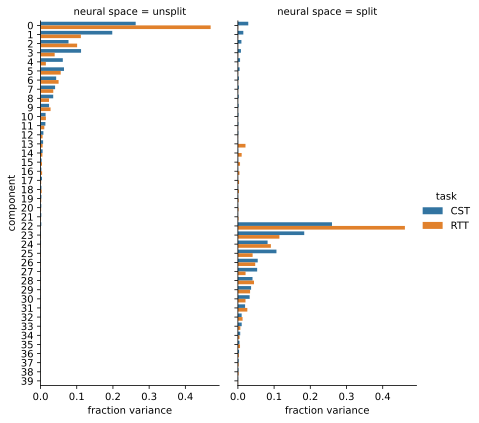

In [2]:
src.plot.plot_split_subspace_variance(td,signal='lfads_rates_joint_pca')

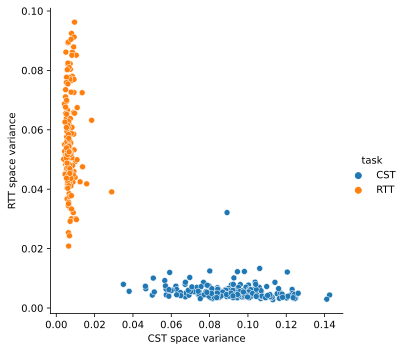

In [3]:
src.plot.plot_single_trial_split_var(td,signal='lfads_rates_joint_pca')

In [47]:
signal = 'lfads_rates_joint_pca_shared'
df = src.decoder_analysis.precondition_td(td, signal)
models = src.decoder_analysis.fit_models(df, signal, target_name='Hand velocity')

trial_scores = src.decoder_analysis.score_trials(df.loc[df['Test set']],signal,models,target_name='Hand velocity')

fig = px.scatter(
    trial_scores.reset_index(),
    x='CST score',
    y='RTT score',
    color='task',
    hover_data=['trial_id'],
    marginal_x='violin',
    marginal_y='violin',
    template='plotly_white',
    width=600,
    height=600,
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig.show()

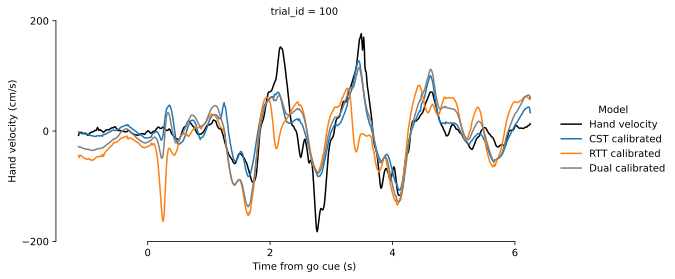

In [48]:
trials_to_plot = [100]
trial_pred = (
    df
    .set_index(['trial_id'])
    .loc[trials_to_plot]
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .reset_index()
    .melt(
        id_vars=['trial_id','Time from go cue (s)','task'],
        value_vars=['Hand velocity','CST calibrated','RTT calibrated','Dual calibrated'],
        var_name='Model',
        value_name='Hand velocity (cm/s)',
    )
)
g=sns.relplot(
    data=trial_pred,
    x='Time from go cue (s)',
    y='Hand velocity (cm/s)',
    hue='Model',
    hue_order=['Hand velocity','CST calibrated','RTT calibrated','Dual calibrated'],
    palette=['k','C0','C1','0.5'],
    kind='line',
    row='trial_id',
    row_order=trials_to_plot,
    height=4,
    aspect=2,
)
g.axes[0,0].set_yticks([-200,0,200])
g.axes[0,0].set_xticks([0,2,4,6])
sns.despine(fig=g.fig,trim=True)

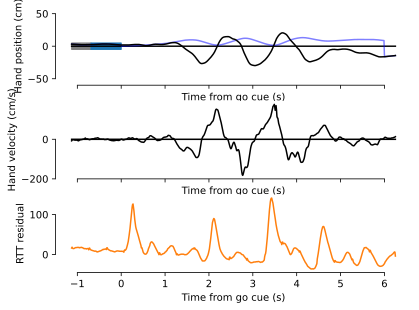

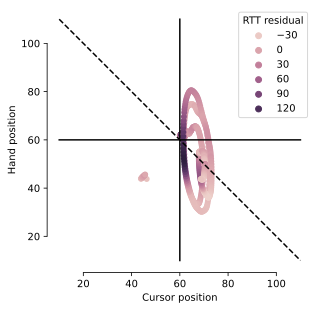

In [49]:
trials_to_plot = [100]
df_resid = (
    df
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .assign(
        **{
            f'{model} residual': lambda d,model=model: d['Dual calibrated']-d[f'{model} calibrated']
            for model in ['CST','RTT']
        }
    )
)
trial_resid = (
    df_resid
    .set_index(['trial_id'])
    .loc[trials_to_plot]
    .reset_index()
)

trial = td.loc[td['trial_id']==trials_to_plot[0],:].squeeze()
fig,axs = plt.subplots(3,1,sharex=True)
src.plot.plot_hand_trace(trial,ax=axs[0],timesig='Time from go cue (s)')
src.plot.plot_hand_velocity(trial,ax=axs[1],timesig='Time from go cue (s)')
sns.lineplot(
    data=trial_resid,
    x='Time from go cue (s)',
    y='RTT residual',
    ax=axs[2],
    color='C1',
)
sns.despine(fig=fig,trim=True)

sm_fig,sm_ax = plt.subplots(1,1)
sns.scatterplot(
    data=trial_resid,
    x='Cursor position',
    y='Hand position',
    hue='RTT residual',
    ax=sm_ax,
    #palette='viridis',
    linewidth=0,
)
sm_ax.plot([60,60],[10,110],'k-')
sm_ax.plot([10,110],[60,60],'k-')
sm_ax.plot([10,110],[110,10],'k--')
sm_ax.set_aspect('equal')
sns.despine(ax=sm_ax,trim=True)

The "joint predicted" and "RTT predicted" decoder predictions are basically scaled and shifted projections of the neural activity along different axes. The two predictions are normally matched with intermittent mismatches, which means that the subspace spanned by the two axes has activity that is one-dimensional most of the time, but sometimes breaks out of the 1D subspace, but only during CST. It would be good here to know what the angles are between the different decoder axes, so let's find out.

In [50]:
joint_axis = models['Dual'].coef_ / np.linalg.norm(models['Dual'].coef_)
rtt_axis = models['RTT'].coef_ / np.linalg.norm(models['RTT'].coef_)
cst_axis = models['CST'].coef_ / np.linalg.norm(models['CST'].coef_)

print(f'angle between dual and rtt axes: {180/np.pi * np.arccos(np.dot(joint_axis,rtt_axis))}')
print(f'angle between dual and cst axes: {180/np.pi * np.arccos(np.dot(joint_axis,cst_axis))}')
print(f'angle between rtt and cst axes: {180/np.pi * np.arccos(np.dot(rtt_axis,cst_axis))}')

angle between dual and rtt axes: 32.158131470773995
angle between dual and cst axes: 35.634190428667786
angle between rtt and cst axes: 65.07711594418181


Following the idea of the subspace spanned by decoder axes, it would be good to know what the angle between different decoder axes is. Let's investigate.

Here, we have a problem: if you have two axes in high-d space, how do you visualize a low-d version of it? That is, how do you find an orthonormal projection of the high-d space that has the same column space as the span of the two axes, and then also plot the two axes into that space as well?

At first, I thought maybe SVD would be the answer, with the $U$ matrix being the orthonormal projection matrix and $SV^H$ being the two axes in that space. But if $SV^H$ is the two axes, then the two axes in that space are necessarily orthogonal, which doesn't make sense--we know that the axes are not orthogonal.

...actually, I take that back--$SV^H$ is not necessarily orthogonal. $V$ is, but when multiplied by $S$, it's not necessarily orthogonal. Still, it may be simpler to use a different method: QR decomposition. QR decomposition will decompose the matrix of two axes into a matrix $Q$ that is orthonormal (a projection matrix to take the neural activity into the input space of the velocity decoders) and a matrix $R$ that is upper triangular (the two axes in the input space of the velocity decoders). One nice aspect of the QR decomposition is that projecting the neural activity through $Q$ will use only the first dimension as the input to the first velocity decoder axis, which makes the decoder axis plots a bit more natural.

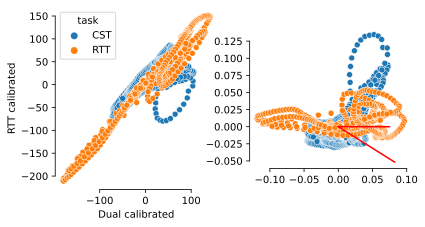

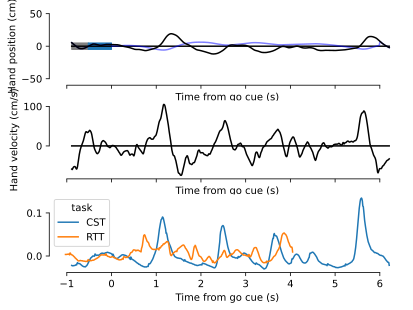

In [77]:
# trials_to_plot = [196,263,322]
# trials_to_plot = [380]
trials_to_plot = [263,380]
trial_pred = (
    df
    .pipe(src.decoder_analysis.model_predict, signal, models)
    .set_index(['trial_id','task','Test set','Time from go cue (s)'])
    .loc[trials_to_plot]
    .reset_index()
)

# Plot out orthonormalized joint and RTT axis projections
axis_to_compare = 'RTT'
Q, R = np.linalg.qr(
    np.column_stack([models['Dual'].coef_,models[axis_to_compare].coef_,models['CST'].coef_]),
)
vel_vectors = -R * 5e-5
# vel_vectors = vh * 0.1

fig,ax = plt.subplots(1,2)
sns.scatterplot(
    data=trial_pred,
    x='Dual calibrated',
    y=f'{axis_to_compare} calibrated',
    hue='task',
    palette=['C0','C1'],
    hue_order=['CST','RTT'],
    ax=ax[0]
)
ax[0].set_aspect('equal')
sns.scatterplot(
    x= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,0],
    y= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,1],
    hue = trial_pred['task'],
    palette=['C0','C1'],
    hue_order=['CST','RTT'],
    ax=ax[1],
    legend=False,
)
ax[1].plot([0,vel_vectors[0,0]],[0,vel_vectors[1,0]],'r-')
ax[1].plot([0,vel_vectors[0,1]],[0,vel_vectors[1,1]],'r-')
ax[1].set_aspect('equal')
sns.despine(fig=fig,trim=True)

fig_3d = px.scatter_3d(
    x= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,0],
    y= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,1],
    z= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,2],
    color= trial_pred['Hand velocity'],
)
# fig_3d.show()

trial = td.loc[td['trial_id']==trials_to_plot[0],:].squeeze()
fig,axs = plt.subplots(3,1,sharex=True)
src.plot.plot_hand_trace(trial,ax=axs[0],timesig='Time from go cue (s)')
src.plot.plot_hand_velocity(trial,ax=axs[1],timesig='Time from go cue (s)')
sns.lineplot(
    x=trial_pred['Time from go cue (s)'],
    y=np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -Q[:,1],
    hue=trial_pred['task'],
    palette=['C0','C1'],
    hue_order=['CST','RTT'], 
    ax=axs[2],
)
sns.despine(fig=fig,trim=True)

Looking at a few RTT and CST trials, it seems like the intermittent failures of the RTT decoder are due to othogonal excursions away from the dual-task calibrated decoder axis. These orhogonal excursions seem to happen mostly during CST trials (indicated by RTT decoder failure), but also seem to happen a bit during RTT trials. In both cases, it seems that these excursions are related somehow to feedback-instigated movements--they generally precede large rightward movements that seem to be corrective of previous "missed" movements (i.e. the monkey didn't move far enough rightward, so he moves rightward again). I'm not sure why this seems so far to be direction-specific, but the behavior also seems to be asymmetric with respect to direction, so maybe that's a simple explanation.

Perhaps a next good step would be to look at all neural activity orthogonal too the dual decoder axis to look for structure.

,trial_id,task,Test set,Time from go cue (s),Hand position,Hand velocity,Cursor position,Cursor velocity,lfads_rates_joint_pca_shared,CST calibrated,RTT calibrated,Dual calibrated
0,263,CST,False,-0.89,65.411541,-58.616008,65.418025,-58.719533,"[-0.23955016402657417, 0.032618898245359226, -...",-26.966892,-25.877139,-46.175207
1,263,CST,False,-0.88,64.810661,-59.750774,64.803811,-59.813556,"[-0.2426787937107682, 0.0270264489639426, -0.0...",-29.825464,-27.672724,-48.631887
2,263,CST,False,-0.87,64.216526,-58.066445,64.221753,-57.821475,"[-0.24067973074557467, 0.025272640962489486, -...",-31.732133,-30.218189,-50.725110
3,263,CST,False,-0.86,63.649332,-55.445222,63.647382,-55.800049,"[-0.23927517490859893, 0.019755991356007314, -...",-33.581074,-31.468781,-52.206544
4,263,CST,False,-0.85,63.107621,-53.544360,63.105752,-53.209122,"[-0.23482668062404582, 0.01658837841098043, -0...",-34.545888,-33.259824,-53.317776
...,...,...,...,...,...,...,...,...,...,...,...,...
1215,380,RTT,False,4.01,86.023738,72.508975,86.021680,72.501169,"[0.28085639715039035, 0.10807473921103965, 0.2...",100.778445,110.785132,118.382908
1216,380,RTT,False,4.02,86.745459,70.314728,86.746756,70.418876,"[0.27315384971107076, 0.1051405833436922, 0.24...",94.572031,106.741403,113.792997
1217,380,RTT,False,4.03,87.430032,66.066344,87.430058,65.976476,"[0.2731209956437639, 0.10867986099735819, 0.25...",90.260338,101.805553,110.087627
1218,380,RTT,False,4.04,88.066786,62.516966,88.066286,62.533822,"[0.25109067155713, 0.09876303340897975, 0.2565...",81.830415,96.255557,102.903288


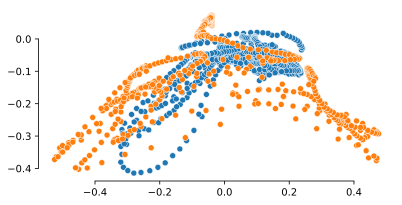

In [79]:
import scipy.linalg
decoder_null_proj = src.dekodec.max_var_rotate(
    scipy.linalg.null_space(models['Dual'].coef_[None,:]),
    np.row_stack(df['lfads_rates_joint_pca_shared'])
)

fig,ax = plt.subplots(1,1)
sns.scatterplot(
    x= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ decoder_null_proj[:,0],
    y= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ decoder_null_proj[:,1],
    # c=trial_pred['Hand velocity'],
    hue = trial_pred['task'],
    palette=['C0','C1'],
    hue_order=['CST','RTT'],
    ax=ax,
    legend=False,
)
ax.set_aspect('equal')
sns.despine(fig=fig,trim=True)

fig_3d = px.scatter_3d(
    x= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -decoder_null_proj[:,0],
    y= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -decoder_null_proj[:,1],
    z= np.row_stack(trial_pred['lfads_rates_joint_pca_shared']) @ -decoder_null_proj[:,2],
    color= trial_pred['task'],
)
fig_3d.show()
trial_pred

In [68]:
temp = (
    df
    .set_index(['trial_id','task','Test set','Time from go cue (s)'])
    .pipe(src.crystal.express_crystallize,single_cols=['Hand position','Hand velocity','Cursor position','Cursor velocity'],array_cols=['lfads_rates_joint_pca_shared'])
)
df

,trial_id,Time from go cue (s),task,Hand position,Hand velocity,Cursor position,Cursor velocity,lfads_rates_joint_pca_shared,Test set
0,1,-0.88,CST,55.975703,5.973144,55.974293,5.729341,"[0.026831161551474546, 0.3025271938110085, -0....",True
0,1,-0.87,CST,56.035850,6.727050,56.033840,7.036972,"[0.02734098912786982, 0.304127771500368, -0.04...",True
0,1,-0.86,CST,56.110244,8.104012,56.115033,7.958073,"[0.022668962426056392, 0.29899330095371845, -0...",True
0,1,-0.85,CST,56.197930,9.122670,56.193002,9.014685,"[0.017991500811348413, 0.2913603691716064, -0....",True
0,1,-0.84,CST,56.292698,9.736655,56.295327,9.986239,"[0.016639424901958594, 0.28546908274512595, -0...",True
...,...,...,...,...,...,...,...,...,...
349,394,2.05,CST,87.525364,-5.893637,87.525579,-5.938797,"[0.007613650820840086, -0.0017151340993745317,...",False
349,394,2.06,CST,87.472279,-5.828899,87.471843,-5.823107,"[0.005666705639953755, 0.005961303952509742, -...",False
349,394,2.07,CST,87.408786,-7.843264,87.409117,-7.822422,"[0.00323466480814096, 0.014057548031348874, -0...",False
349,394,2.08,CST,87.315414,-10.834871,87.315395,-10.855589,"[-0.00776316854899635, 0.008848790413446234, -...",False
